In [611]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [612]:
data = np.load("hsc_stacked.npy")

In [613]:
redshifts = data['z_cl']

# Bin the cluster data by redshift
clusters1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
clusters2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
clusters3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
clusters4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
clusters5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [614]:
num_radial_bins = 15

In [695]:
# Compute the average colors (and their variances) for a given redshift bin

def get_clusters_data(clusters):
    
    clusters = clusters[np.where(clusters['R'] > 0.1)]
    radii = np.array(clusters['R'])
    
    # Arrays containing magnitude data in four different filters
    g = np.array(clusters['gmag_forced_cmodel'])
    r = np.array(clusters['rmag_forced_cmodel'])
    i = np.array(clusters['imag_forced_cmodel'])
    z = np.array(clusters['zmag_forced_cmodel'])
    
    g_pruned = g[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    r_pruned = r[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    i_pruned = i[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    z_pruned = z[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]

    radii_pruned = radii[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    radial_bins = np.logspace(np.log10(np.amin(radii_pruned)), np.log10(0.9*np.amax(radii_pruned)), num_radial_bins + 1)
    widths = np.diff(radial_bins)
    annular_areas = np.pi * np.diff(radial_bins ** 2.)

    
    # For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
    # arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
    # compute the number of objects and the sum and variance (noise^2) of the color values in those bins

    
    gr = g_pruned - r_pruned
    counts = binned_statistic(radii_pruned, gr, 'count', radial_bins)[0]
    sum_gr = binned_statistic(radii_pruned, gr, 'sum', radial_bins)[0]
    var_gr = binned_statistic(radii_pruned, gr, np.var, radial_bins)[0]
    var_gr *= counts

    ri = r_pruned - i_pruned
    sum_ri = binned_statistic(radii_pruned, ri, 'sum', radial_bins)[0]
    var_ri = binned_statistic(radii_pruned, ri, np.var, radial_bins)[0]
    var_ri *= counts

    iz = i_pruned - z_pruned
    sum_iz = binned_statistic(radii_pruned, iz, 'sum', radial_bins)[0]
    var_iz = binned_statistic(radii_pruned, iz, np.var, radial_bins)[0]
    var_iz *= counts
    
    g_mean_outer = binned_statistic(radii_pruned, g_pruned, 'mean', radial_bins)[0][-1]
    r_mean_outer = binned_statistic(radii_pruned, r_pruned, 'mean', radial_bins)[0][-1]
    i_mean_outer = binned_statistic(radii_pruned, i_pruned, 'mean', radial_bins)[0][-1]
    z_mean_outer = binned_statistic(radii_pruned, z_pruned, 'mean', radial_bins)[0][-1]
    
    gr_mean_outer = g_mean_outer - r_mean_outer
    ri_mean_outer = r_mean_outer - i_mean_outer
    iz_mean_outer = i_mean_outer - z_mean_outer
    
    return (radial_bins, widths, annular_areas, counts, (sum_gr, var_gr), (sum_ri, var_ri), (sum_iz, var_iz),
           (gr_mean_outer, ri_mean_outer, iz_mean_outer))

In [748]:
# Use NMF to unmix the color profiles generated by plot_profiles and avg_colors
# The arguments of "unmix" are 2-tuples of the form (mean_color, var_color). For example, gr is really (mean_gr, var_gr)

def prox_field(S, step):
    S[0, :] = 1
    #S[1:, -1] = 0
    S[1:, :] /= S[1:,:].max(axis=1)[:,None]
    return S

def prox_ndens(X, step):
    X[0, :] = np.maximum(0, X[0, :])

def unmix(counts, gr, ri, iz, annular_areas):
    n = num_radial_bins     # component resolution
    k = 2                   # number of components
    b = 4                   # number of observations (b=4 for counts, g-r, r-i, and i-z)

    # Data matrix to be unmixed
    Y = np.array([counts, gr[0], ri[0], iz[0]]) / annular_areas
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = 1. / (np.array([counts, gr[1], ri[1], iz[1]]) / annular_areas**2)

    # initialize and run NMF
    A = np.random.uniform(size = (b, k))
    S = np.random.uniform(size = (k, n))
    
    pA = po.prox_id
    pS = po.AlternatingProjections([prox_field, po.prox_plus])
    
    nmf(Y, A, S, W=W, prox_A=pA, prox_S=pS, e_rel=1e-6, e_abs=0)
    
    return A, S

In [749]:
def plot_profiles(clusters_data, z_bin_num, area_normalization=True):
    

    radial_bins = clusters_data[0]
    bin_midpoints = (radial_bins[1:] * radial_bins[:-1]) ** 0.5
    widths = clusters_data[1]
    annular_areas = clusters_data[2]
    counts = clusters_data[3]
    
    # gr, ri, iz, are 2-tuples of the form (sum_color, var_color)
    gr = clusters_data[4]
    ri = clusters_data[5]
    iz = clusters_data[6]
    
    A, S = unmix(counts, gr, ri, iz, annular_areas)
    print("A:\n", A, "\n")
    print("S:\n", S, "\n")
    
    print("Relative fraction of field vs. cluster members: ", A[0] / A[0].sum(), "\n")
    print("Average colors of field: ", (A[1:,0] / A[0,0]).T, "\n")
    print("Average colors of cluster members: ", (A[1:,1] / A[0,1]).T, "\n")
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")
    
    # Plot S_k (the relative abundance of the kth component) vs. radius for each k
    
    for k in range(S.shape[0]):
        plt.plot(bin_midpoints, S[k], label = "Component %s" % (k+1))
    plt.xscale('log')
    plt.title("Spatial Distribution of Components for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel("S(R)")
    plt.legend()
    plt.show()
    

    Y_remixed = np.dot(A, S)
    
    # Plot the reconstructed color profiles following NMF 
    # (that is, plot Y_remixed = A x S, where A and S are the results of factorizing the initial data matrix Y)
    
    if(area_normalization):
        
        plt.bar(radial_bins[:-1], counts/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(counts/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[0], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[0,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("Galaxy Number Density vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"Number Density $[\frac{counts}{Mpc^2}]$")
        plt.legend()
        plt.show()
        
        plt.bar(radial_bins[:-1], gr[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(gr[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[1], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[1,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("g-r Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{g-r}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], ri[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(ri[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[2], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[2,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("r-i Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{r-i}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], iz[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(iz[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[3], label="Predicted Profile")
        for k in range(S.shape[0]):
            plt.plot(bin_midpoints, A[3,k] * S[k], label = "Component %s" % (k+1))
        plt.xscale('log')
        plt.title("i-z Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{i-z}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        
    else:
        plt.bar(radial_bins[:-1], gr[0], width=widths, align="edge", yerr=np.sqrt(gr[1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[1], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average g-r [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], ri[0], width=widths, align="edge", yerr=np.sqrt(ri[1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[2], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average r-i [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], iz[0], width=widths, align="edge", yerr=np.sqrt(iz[1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[3], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average i-z [magnitudes]")
        plt.legend()
        plt.show()

In [750]:
#Extract data from clusters1

clusters1_data = get_clusters_data(clusters1)
print(clusters1_data[-1])

(0.70314623819641398, 0.51939873721561014, 0.32739560790720645)


A:
 [[ 7099.05468837  2049.00746088]
 [ 5005.11452411  1791.63817796]
 [ 3735.89531744   816.88291276]
 [ 2360.30789696   541.76478134]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.7078204   0.71195184  1.          0.31122989  0.36488248  0.14048088
   0.40688674  0.0273104   0.04144171  0.19826764  0.11306224  0.31047693
   0.38634425  0.56827252  0.72210095]] 

Relative fraction of field vs. cluster members:  [ 0.77601732  0.22398268] 

Average colors of field:  [ 0.70503958  0.52625251  0.332482  ] 

Average colors of cluster members:  [ 0.87439319  0.39867249  0.26440352] 



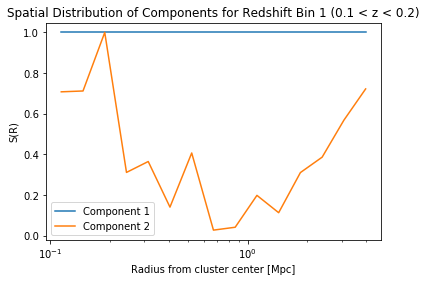

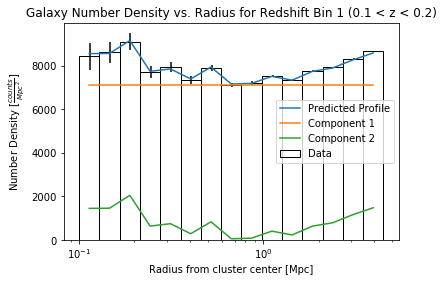

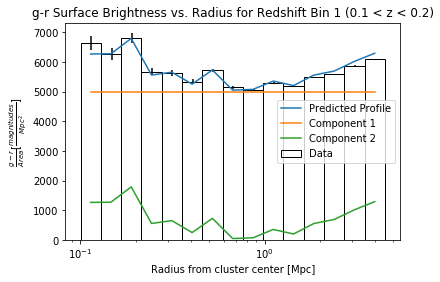

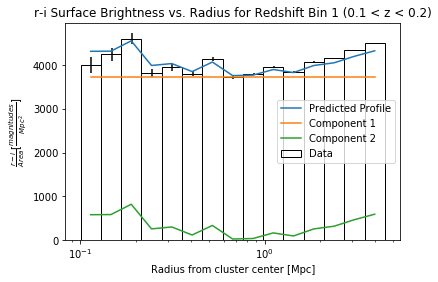

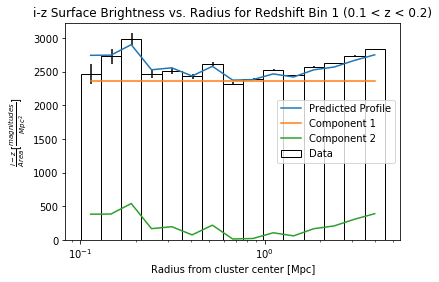

In [760]:
#Plot bar graphs for the post-NMF clusters1 profiles

plot_profiles(clusters1_data, 1, area_normalization=True)

In [752]:
#Plot bar graphs for the clusters2 data

clusters2_data = get_clusters_data(clusters2)
print(clusters2_data[-1])

(0.70050210582395067, 0.52163407111062199, 0.32835539425045113)


A:
 [[ 14594.9822789    8851.17714111]
 [  9912.48093363  10487.11983292]
 [  7679.39632462   3955.3701205 ]
 [  4801.4894445    2463.73934397]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.73235938  0.61755781  0.56497621  0.5752977   0.43851549
   0.30470247  0.27194609  0.15516927  0.12828133  0.09785661  0.10601424
   0.10921455  0.10765317  0.0527904 ]] 

Relative fraction of field vs. cluster members:  [ 0.62248925  0.37751075] 

Average colors of field:  [ 0.67917047  0.52616688  0.3289822 ] 

Average colors of cluster members:  [ 1.1848277   0.44687504  0.2783516 ] 



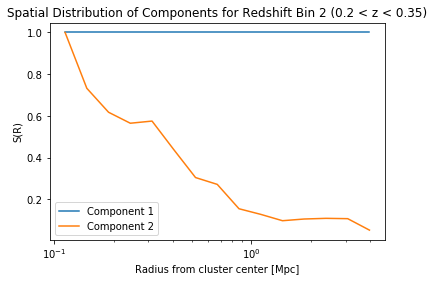

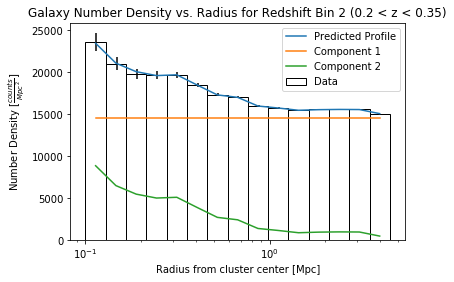

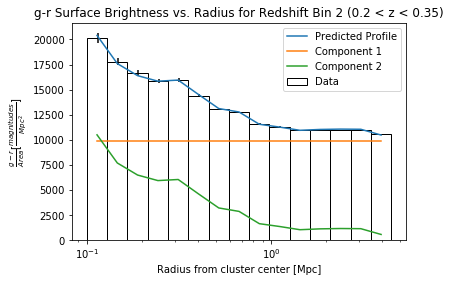

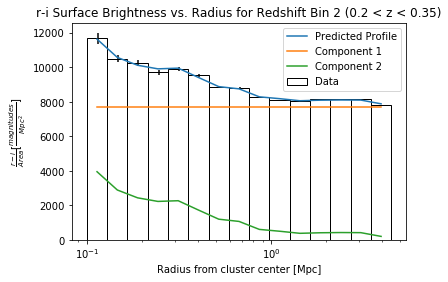

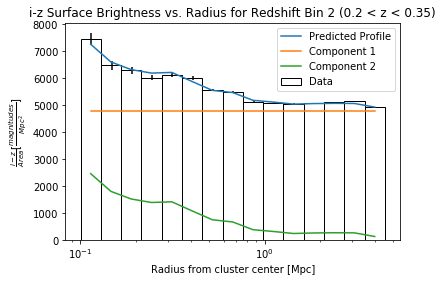

In [753]:
#Plot bar graphs for the post-NMF clusters2 profiles

plot_profiles(clusters2_data, 2, area_normalization=True)

In [754]:
#Plot bar graphs for the clusters3 data

clusters3_data = get_clusters_data(clusters3)
print(clusters3_data[-1])

(0.71084960864074631, 0.52266548413645353, 0.33269176142890799)


A:
 [[ 5550.31095971  4691.71152996]
 [ 3961.2369247   6011.33753466]
 [ 2874.57374602  2624.47309626]
 [ 1833.60958473  1465.58646853]] 

S:
 [[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  8.88213122e-01   1.00000000e+00   7.51073084e-01   6.37132962e-01
    5.47096706e-01   4.68136410e-01   3.46288411e-01   2.22503307e-01
    1.58400876e-01   1.11501250e-01   4.93198000e-02   0.00000000e+00
    3.46152693e-03   9.15849518e-03   2.09038855e-04]] 

Relative fraction of field vs. cluster members:  [ 0.54191552  0.45808448] 

Average colors of field:  [ 0.7136964  0.5179122  0.3303616] 

Average colors of cluster members:  [ 1.28126751  0.55938501  0.31237779] 



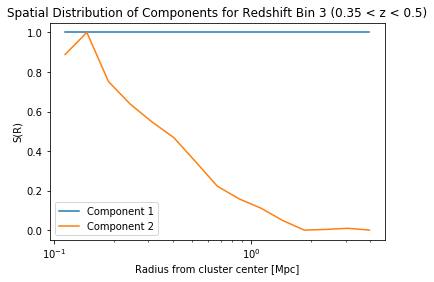

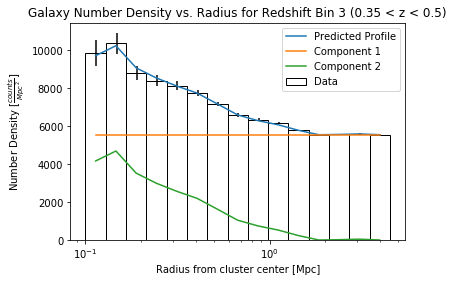

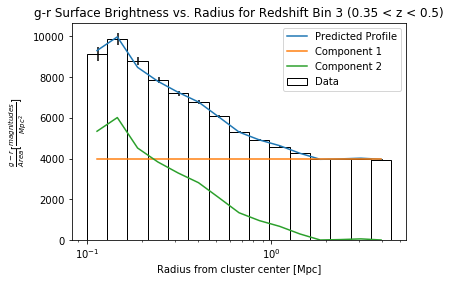

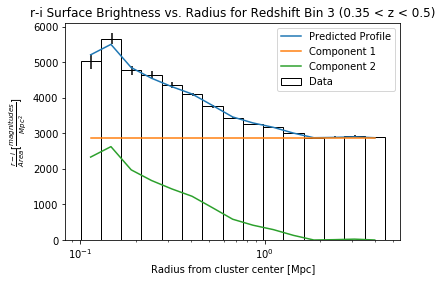

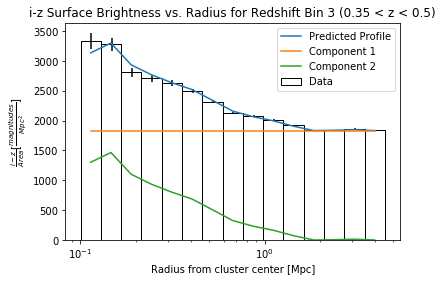

In [755]:
#Plot bar graphs for the post-NMF clusters3 profiles

plot_profiles(clusters3_data, 3, area_normalization=True)

In [756]:
#Plot bar graphs for the clusters4 data

clusters4_data = get_clusters_data(clusters4)
print(clusters4_data[-1])

(0.71422095253073792, 0.5245941396070144, 0.32660814984279796)


A:
 [[ 2870.19000835  4043.39098325]
 [ 2042.906239    5754.16037377]
 [ 1486.34691053  3868.11801945]
 [  901.5954589   1637.30103522]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.67173313  0.52561283  0.37813233  0.30573914  0.24653805
   0.17591433  0.1104947   0.06730368  0.04021971  0.02121335  0.02968517
   0.01555044  0.01358893  0.01649563]] 

Relative fraction of field vs. cluster members:  [ 0.41515244  0.58484756] 

Average colors of field:  [ 0.7117669   0.51785662  0.31412396] 

Average colors of cluster members:  [ 1.42310264  0.95665199  0.40493265] 



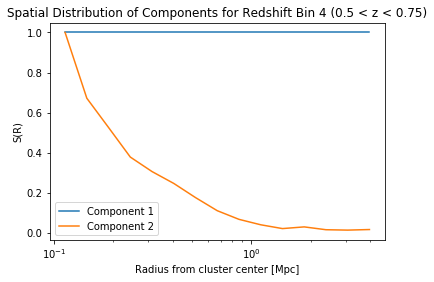

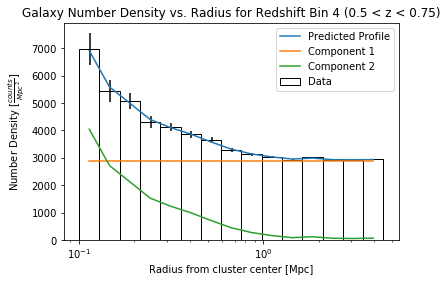

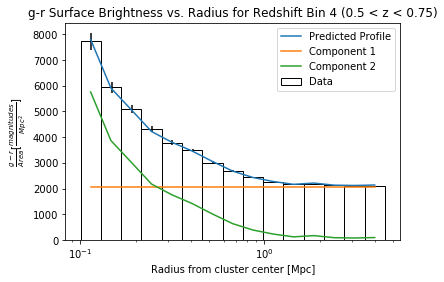

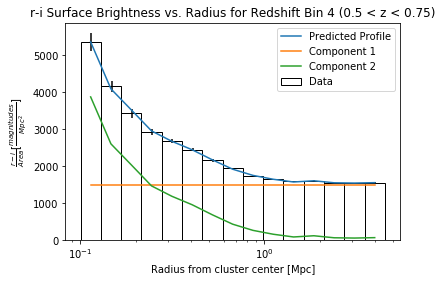

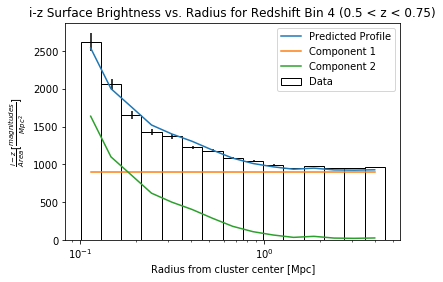

In [757]:
#Plot bar graphs for the post-NMF clusters4 profiles

plot_profiles(clusters4_data, 4, area_normalization=True)

In [758]:
#Plot bar graphs for the clusters5 data

clusters5_data = get_clusters_data(clusters5)
print(clusters5_data[-1])

(0.70324427640557019, 0.53783751939062796, 0.33762896547291632)


A:
 [[ 1933.53119714  3714.5202679 ]
 [ 1083.50808673  5261.17299283]
 [  888.21544446  3921.45293045]
 [  569.310504    2141.75819338]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.6508515   0.51353056  0.46637134  0.4135714   0.31489371
   0.26313695  0.24410772  0.19581212  0.16123183  0.12758194  0.08347489
   0.06790197  0.06763648  0.06305613]] 

Relative fraction of field vs. cluster members:  [ 0.34233597  0.65766403] 

Average colors of field:  [ 0.56037787  0.45937477  0.29444082] 

Average colors of cluster members:  [ 1.41638021  1.05570912  0.57659079] 



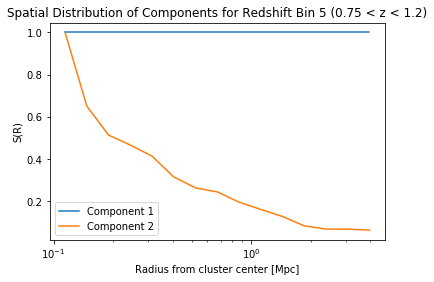

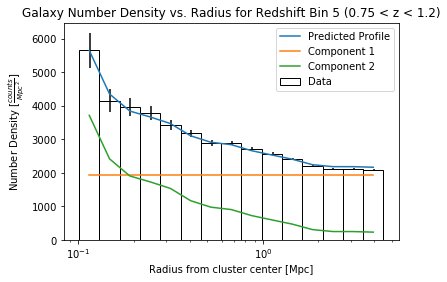

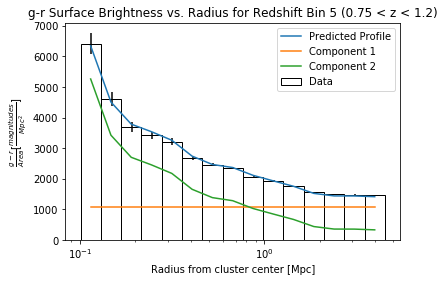

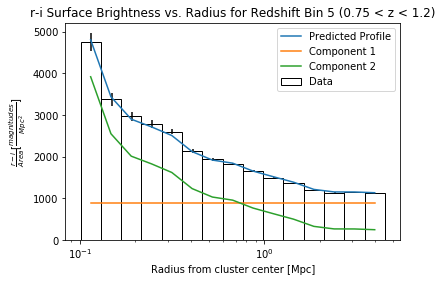

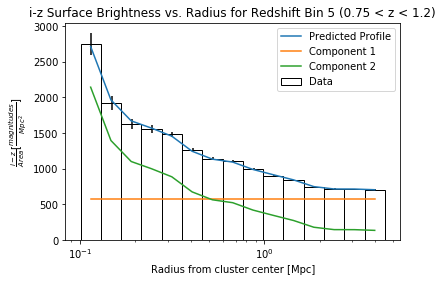

In [759]:
#Plot bar graphs for the post-NMF clusters5 profiles

plot_profiles(clusters5_data, 5, area_normalization=True)